In [30]:
#basic imports and reading data (creating dataframe)

import pandas as pd
import numpy as np

data = pd.read_csv('dataset_for_assignment.csv', error_bad_lines=False)
data.head(10)

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


## Downloading stopwords (english) and making set of stopwords

In [31]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
russian_stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmlitov4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Function for text cleaning (letters only, lowercase, deleting stopwords) and applying it to rows

In [32]:
import re

def cleaning_text(message, remove_stopwords):
    letters = re.sub('[^a-zA-Z]', ' ' , message)
    words = letters.lower().split()
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]
    return ' '.join(words)

In [33]:
data['cleaned'] = data.apply(lambda row: cleaning_text(str(row['comment_text']), True), axis=1)

In [34]:
data.head(10)

,comment_text,target,cleaned
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations well use tools well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article reverted pl...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intending...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


In [35]:
data.shape

(159571, 3)

In [36]:
data['target'].value_counts()

0    143346
1     16225
Name: target, dtype: int64

### Hmmm... It seems like classes are imbalanced (a lot). Let's perform downsampling! (cause 16+ k rows is enough for this task I guess)

In [38]:
from sklearn.utils import resample

df_majority = data[data.target==0]
df_minority = data[data.target==1]
 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=17000,     # to match minority class
                                 random_state=123) # reproducible results
 
data = pd.concat([df_majority_downsampled, df_minority])

In [39]:
data['target'].value_counts()

0    17000
1    16225
Name: target, dtype: int64

## Creating X_train, y_train

In [59]:
data['cleaned'] = data.apply(lambda row: str(row['cleaned']), axis=1)
x_train = data['cleaned']
y_train = data[['target']].values

In [60]:
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

tok = text.Tokenizer(num_words=45000)
tok.fit_on_texts(list(x_train))
x_train = tok.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(x_train,maxlen=150)

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=123)

In [62]:
import sys
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
import utils
from keras.preprocessing.sequence import pad_sequences

model = Sequential()
model.add(Embedding(45000, 32, input_length=150))
model.add(Dropout(0.25))
model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
model.add(Conv1D(128, 3, padding='valid', activation='relu', strides=1))
model.add(Conv1D(64, 3, padding='valid', activation='relu', strides=1))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint('dodo_test_best.hdf5', monitor="loss", save_best_only=True, mode='min')
history = model.fit(x_train, y_train, batch_size=128, validation_data=(x_test, y_test), epochs=3, shuffle=True, callbacks=[checkpoint])

Train on 23257 samples, validate on 9968 samples
Epoch 1/3
23257/23257 [==============================] - 92s 4ms/step - loss: 0.5793 - acc: 0.7712 - val_loss: 0.2833 - val_acc: 0.9069
Epoch 2/3
23257/23257 [==============================] - 96s 4ms/step - loss: 0.2225 - acc: 0.9318 - val_loss: 0.2714 - val_acc: 0.9110
Epoch 3/3
23257/23257 [==============================] - 88s 4ms/step - loss: 0.1566 - acc: 0.9586 - val_loss: 0.3022 - val_acc: 0.9015


In [63]:
res = model.evaluate(x_test, y_test, batch_size=64)
print(res)

9968/9968 [==============================] - 11s 1ms/step
[0.30222536025518015, 0.9014847511081787]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


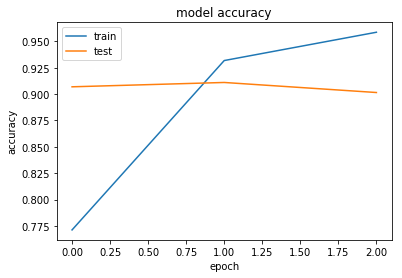

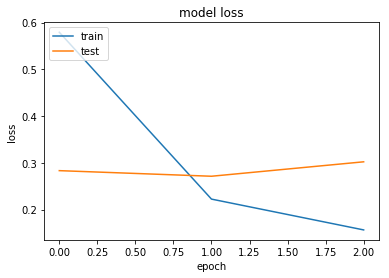

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
num_of_phrases = int(input('Enter number of phrases: '))
for i in range(num_of_phrases):
    phrases = []
    inp = input()
    
    inp = cleaning_text(inp, True)
    phrases.append(inp)

    checks = tok.texts_to_sequences(phrases)
    checks = sequence.pad_sequences(checks,maxlen=150)
    answers = model.predict(checks, batch_size=128)
    pairs = list(zip(phrases, answers))
    for x in pairs:
        print(x)

Enter number of phrases: 5
Wonderful day, thanks
('wonderful day thanks', array([0.11700603], dtype=float32))
Amazing guys, it is nice
('amazing guys nice', array([0.6027536], dtype=float32))
I am very angry and sad
('angry sad', array([0.69576], dtype=float32))
Fuck you, it is bullshit
('fuck bullshit', array([0.9999993], dtype=float32))
It sucks really
('sucks really', array([0.9789869], dtype=float32))


In [50]:
model.save('dodo_cnn_sentiment2.hdf5')

In [51]:
import pickle

with open('dodo_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [69]:
from sklearn.metrics import classification_report

pred = model.predict(x_test, batch_size=64)
pred = pred.tolist()
pred = list(map(lambda current: 0 if current[0] < 0.5 else 1, pred))
y_test_new = list(map(lambda current: current[0], y_test))
report = classification_report(y_test_new, pred)
print(report)

             precision    recall  f1-score   support

          0       0.93      0.87      0.90      5028
          1       0.88      0.93      0.90      4940

avg / total       0.90      0.90      0.90      9968

